In [1]:
import sys
sys.path.append('..')
import dependencies
import soft_dependencies

Python Version 3.9.12 (main, Jun  1 2022, 06:36:29) 
[Clang 12.0.0 ]
Numpy Version 1.22.2
Scipy Version 1.7.3
Sklearn Version 1.0.2
Matplotlib Version 3.5.1
Pandas Version 1.4.2
Line Profiler Version 3.3.1
Memory Profiler Version 0.58.0


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import glob

In [3]:
from Scripts.nonparanormal_skeptic import nonparanormal_skeptic
from Scripts.anBiGLasso_cov import anBiGLasso
from Scripts.EiGLasso import EiGLasso_cov as EiGLasso
from Scripts.scBiGLasso import scBiGLasso_cov as scBiGLasso
from Scripts.utilities import binarize_matrix
from Scripts.antGLasso import antGLasso, antGLasso_heuristic
from Scripts.nonparanormal_skeptic import nonparanormal_tensor_skeptic

In [4]:
np.set_printoptions(precision=3, suppress=True)
%load_ext line_profiler
%load_ext memory_profiler
%load_ext autoreload
%autoreload 2

# COIL Data
From the 'processed' dataset available here: https://cave.cs.columbia.edu/repository/COIL-20

We only look at the duck data.

<IPython.core.display.Javascript object>


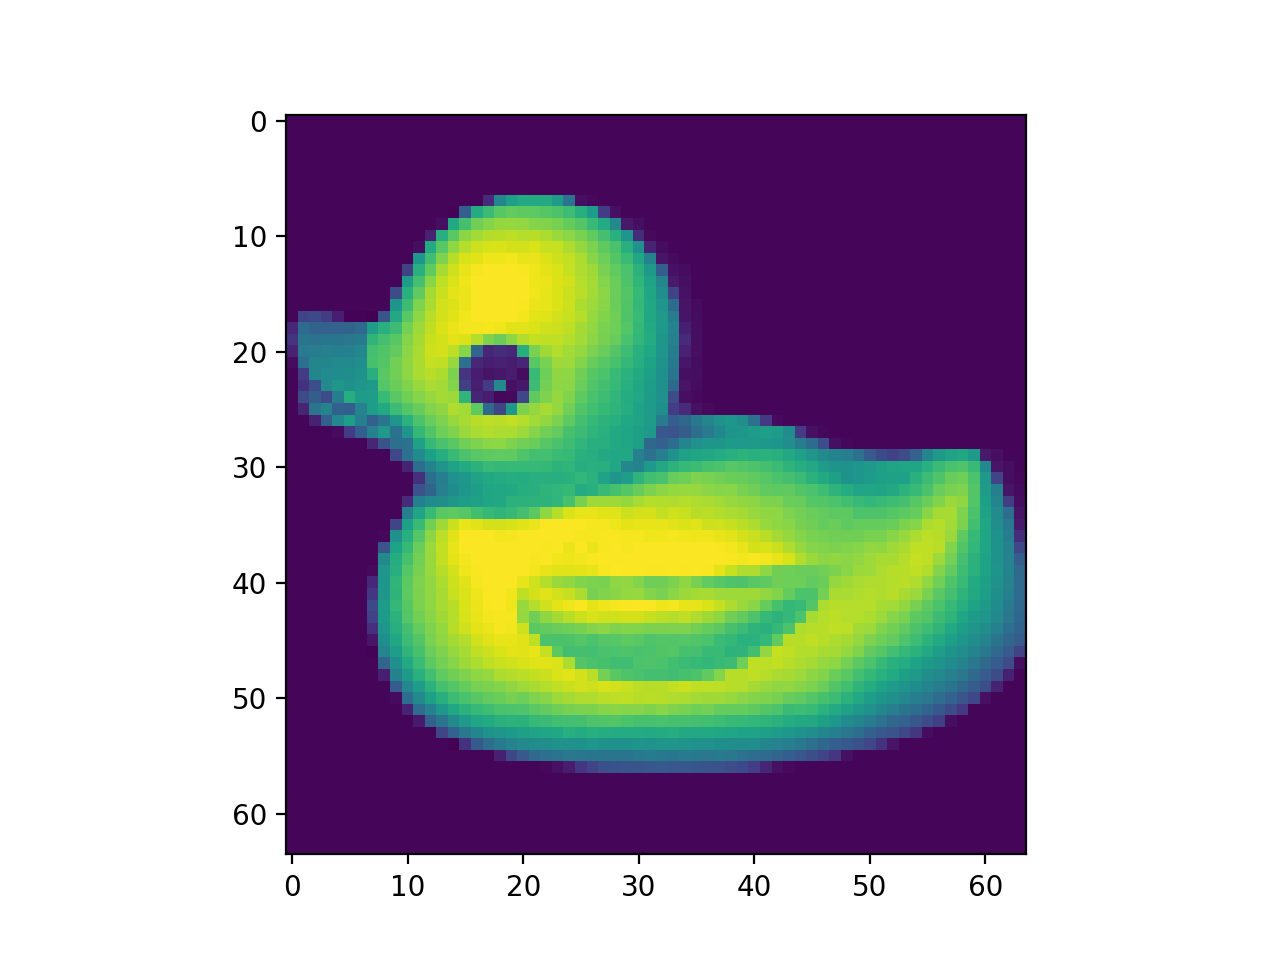

In [104]:
# Here we load the image, and optionally drop every `imsize_factor`th pixel
# if we want to minimize pixels.  In the BiGLasso paper, they considered 9 by 9
# We consider the 64x64 case
import glob
imsize_factor = 2
imsize = 128 // imsize_factor
files = sorted(glob.glob('../../Data/coil-20-proc/*.png'))
duck_mat = np.array(
    [np.array(Image.open(f))[::imsize_factor, ::imsize_factor].reshape(imsize**2) for f in files],
    dtype=np.int16
).reshape((20, 72, imsize**2))
duck_mat.shape # object, frame, flattened pixel
plt.imshow(duck_mat[10, 0].reshape(imsize, imsize))

In [105]:
T, S = nonparanormal_skeptic(duck_mat[10][np.newaxis, ::, ...]) 

In [259]:
# Run if don't want to use the skeptic
dm = duck_mat[10].astype(np.float64)
T = dm @ dm.T / imsize**2
S = dm.T @ dm / 72

In [298]:
Psi, Theta = scBiGLasso(100, 1e-6, T, S, beta_1 = 167500, beta_2 = 0.0005)
print(Psi)

[[ 1. -0. -0. ... -0. -0. -0.]
 [-0.  1. -0. ... -0. -0. -0.]
 [-0. -0.  1. ... -0. -0. -0.]
 ...
 [-0. -0. -0. ...  1. -0. -0.]
 [-0. -0. -0. ... -0.  1.  0.]
 [-0. -0. -0. ... -0.  0.  1.]]


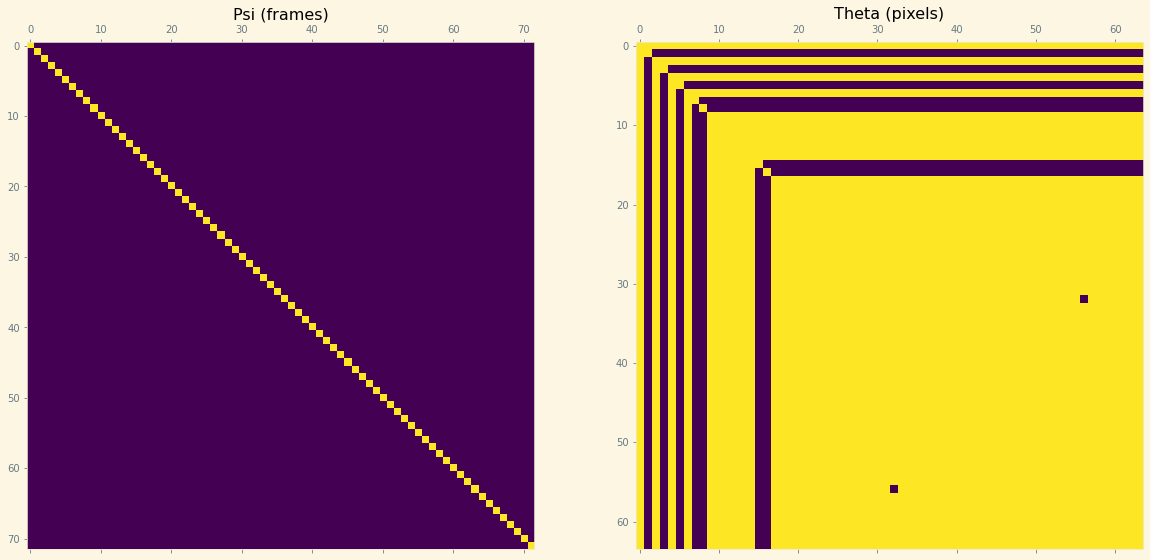

In [299]:
Psi_ = binarize_matrix(Psi, mode='Nonzero')
np.fill_diagonal(Psi_, 1)
Theta_ = binarize_matrix(Theta, mode='Nonzero')
np.fill_diagonal(Theta_, 1)

with plt.style.context('Solarize_Light2'):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 10))
    
    ax1.grid(False)
    ax1.matshow(Psi_)
    ax1.set_title('Psi (frames)')
    
    ax2.matshow(Theta_)
    ax2.grid(False)
    ax2.set_title('Theta (pixels)')
    
    # Add gridlines for pixel rows
    # We skip rows b/c otherwise it would be too cluttered
    #for i in range(16):
    #    ax2.axvline(64*i)
    #    ax2.axhline(64*i)

In [301]:
Psi, Theta = EiGLasso(T, S, beta_1 = 0.5, beta_2 = 0.8)

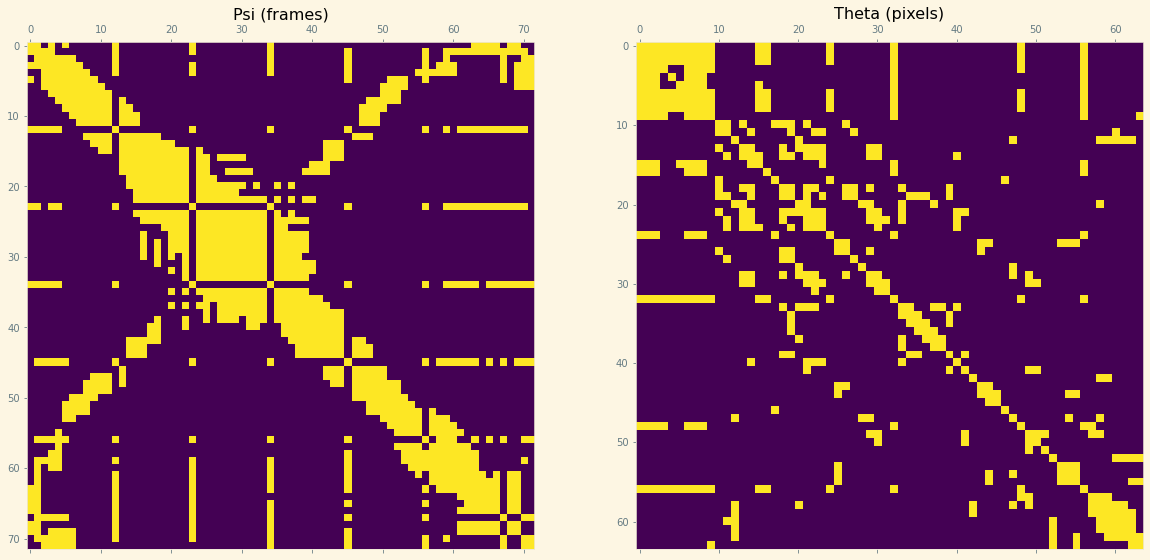

In [302]:
Psi_ = binarize_matrix(Psi, mode='Nonzero')
np.fill_diagonal(Psi_, 1)
Theta_ = binarize_matrix(Theta, mode='Nonzero')
np.fill_diagonal(Theta_, 1)

with plt.style.context('Solarize_Light2'):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 10))
    
    ax1.grid(False)
    ax1.matshow(Psi_)
    ax1.set_title('Psi (frames)')
    
    ax2.matshow(Theta_)
    ax2.grid(False)
    ax2.set_title('Theta (pixels)')
    
    # Add gridlines for pixel rows
    # We skip rows b/c otherwise it would be too cluttered
    #for i in range(16):
    #    ax2.axvline(64*i)
    #    ax2.axhline(64*i)

In [98]:
from Scripts.anBiGLasso import calculateEigenvalues, eigenvectors_MLE
from Scripts.anBiGLasso_cov import eigenvalues_MLE
# Runtime analysis
%lprun -f anBiGLasso -f calculateEigenvalues -f eigenvalues_MLE -f eigenvectors_MLE \
    anBiGLasso(T, S, beta_1 = 0.002, beta_2 = 0.002, B_approx_iters=1000)

In [101]:
from Scripts.antGLasso import calculateEigenvalues, eigenvectors_MLE, eigenvalues_MLE
# Runtime analysis
%lprun -f antGLasso -f calculateEigenvalues -f eigenvalues_MLE -f eigenvectors_MLE \
    antGLasso(duck_mat[10:11, :100, :100], betas = [0.002, 0.002], B_approx_iters=100)

In [103]:
from Scripts.antGLasso import calculateEigenvalues, eigenvectors_MLE, eigenvalues_MLE
# Runtime analysis
%lprun -f antGLasso -f calculateEigenvalues -f eigenvalues_MLE -f eigenvectors_MLE \
    antGLasso(duck_tens[10:11], betas = [0.002, 0.002, 0.002], B_approx_iters=100)

In [55]:
Psi, Theta = anBiGLasso(T, S, beta_1 = 0.1, beta_2 = 0.5, B_approx_iters = 10)
"""
from scipy.stats import norm
Psi, Theta = raw_anBiGLasso(
    duck_mat[10][np.newaxis, ...],
    beta_1 = 1e25,
    beta_2 = 0.002,
    B_approx_iters = 1000
)
print(Psi)
"""
print(Psi)

[[-0.252 -0.221  0.    ... -0.222  0.     0.   ]
 [-0.221 -0.313  0.    ... -0.011  0.     0.   ]
 [ 0.     0.    -0.083 ...  0.     0.    -0.404]
 ...
 [-0.222 -0.011  0.    ... -0.119  0.     0.   ]
 [ 0.     0.     0.    ...  0.    -0.07  -0.484]
 [ 0.     0.    -0.404 ...  0.    -0.484 -0.021]]


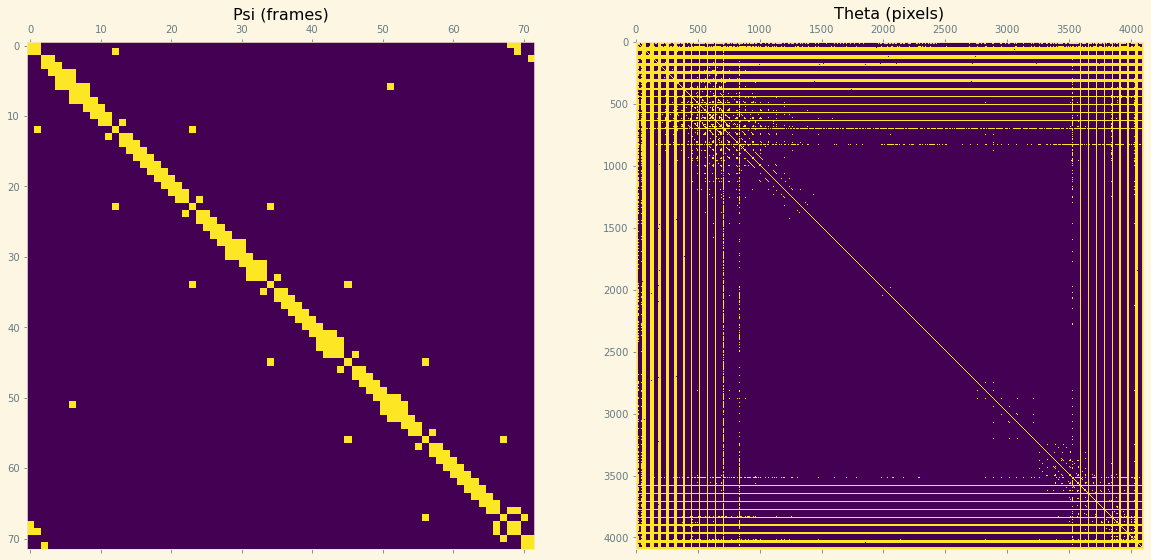

In [56]:
Psi_ = binarize_matrix(Psi, mode='Nonzero')
np.fill_diagonal(Psi_, 1)
Theta_ = binarize_matrix(Theta, mode='Nonzero')
np.fill_diagonal(Theta_, 1)

with plt.style.context('Solarize_Light2'):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 10))
    
    ax1.grid(False)
    ax1.matshow(Psi_)
    ax1.set_title('Psi (frames)')
    
    ax2.matshow(Theta_)
    ax2.grid(False)
    ax2.set_title('Theta (pixels)')
    
    # Add gridlines for pixel rows
    # We skip rows b/c otherwise it would be too cluttered
    #for i in range(16):
    #    ax2.axvline(64*i)
    #    ax2.axhline(64*i)
    #fig.savefig('../../Plots/Duck/anBiGLasso Performance.png')

In [106]:
from Scripts.nonparanormal_skeptic import nonparanormal_tensor_skeptic
#T, S = nonparanormal_skeptic(duck_mat[10][np.newaxis, ::, ...])
T, S = nonparanormal_tensor_skeptic(duck_mat[10][np.newaxis, ::, ...])

In [113]:
from Scripts.antGLasso import antGLasso_heuristic
#Theta, Psi = anBiGLasso(T, S, beta_1 = 0.1, beta_2 = 0.1, B_approx_iters=10)
Psi, Theta = antGLasso_heuristic([T, S], sparsities=[0.025, 0.1], B_approx_iters=100)

<IPython.core.display.Javascript object>


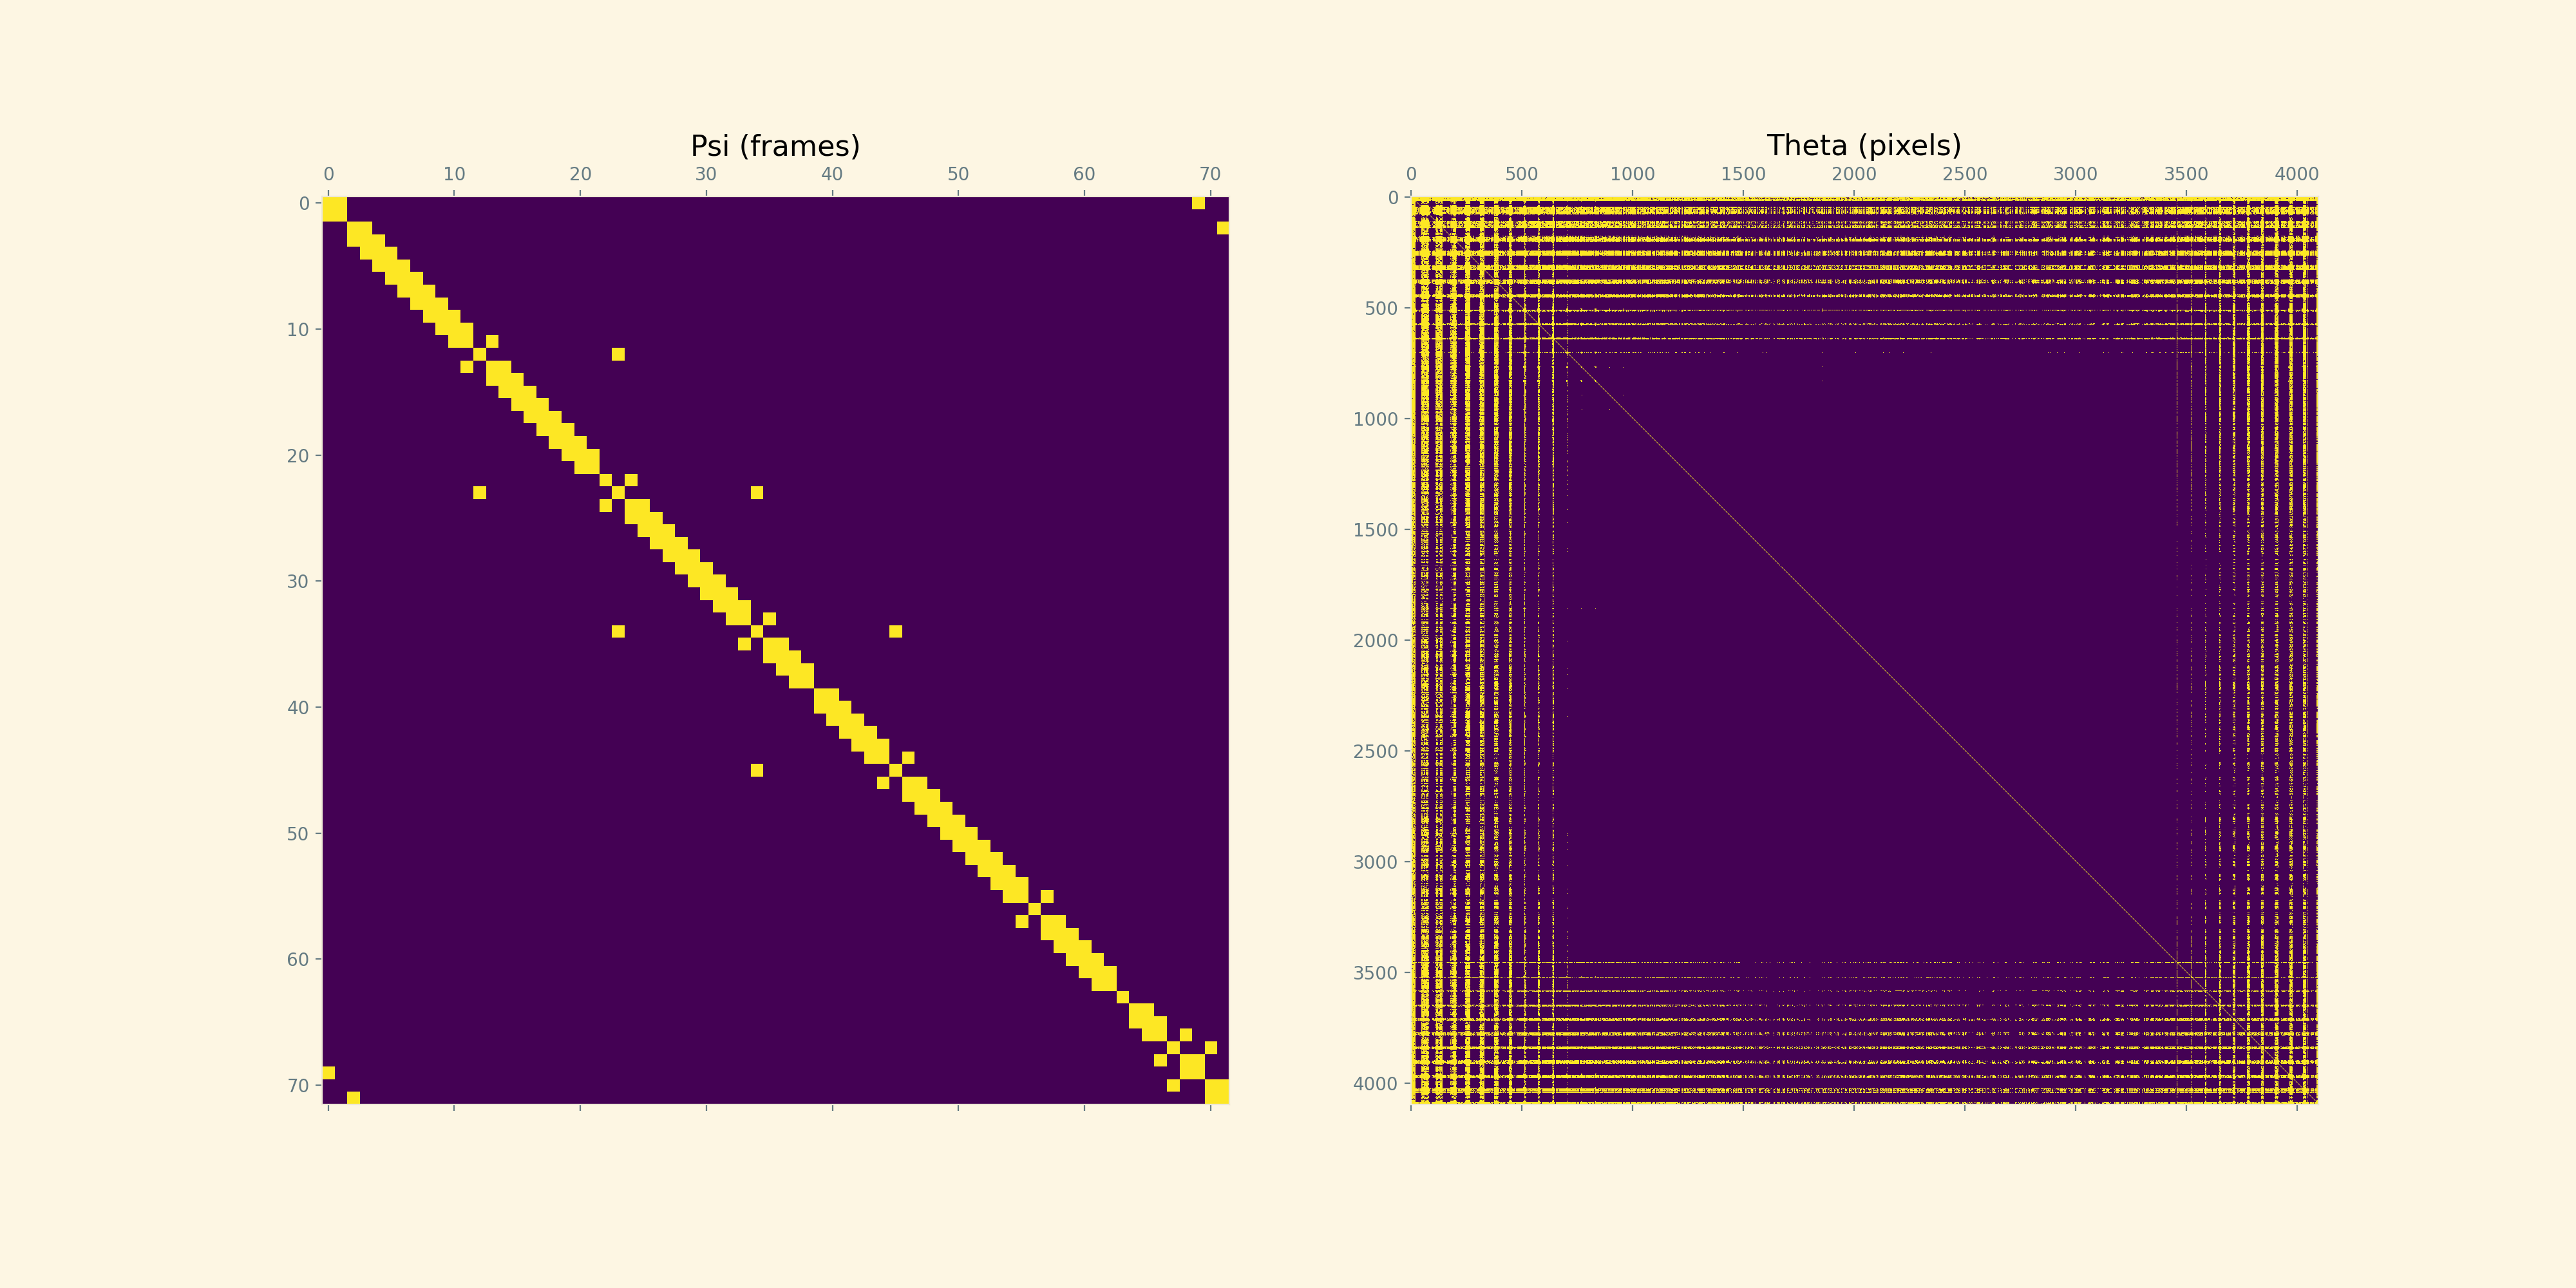

In [114]:
Psi_ = binarize_matrix(Psi, mode='Nonzero')
np.fill_diagonal(Psi_, 1)
Theta_ = binarize_matrix(Theta, mode='Nonzero')
np.fill_diagonal(Theta_, 1)

with plt.style.context('Solarize_Light2'):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 10))
    
    ax1.grid(False)
    ax1.matshow(Psi_)
    ax1.set_title('Psi (frames)')
    
    ax2.matshow(Theta_)
    ax2.grid(False)
    ax2.set_title('Theta (pixels)')
    
    # Add gridlines for pixel rows
    # We skip rows b/c otherwise it would be too cluttered
    #for i in range(16):
    #    ax2.axvline(64*i)
    #    ax2.axhline(64*i)
    fig.savefig('../../Plots/Final/antGLasso Duck Heuristic.png')

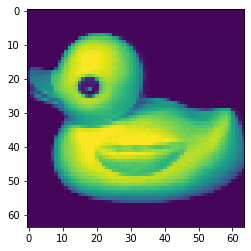

In [295]:
duck_mat_ = np.array(
    [np.array(Image.open(f))[::imsize_factor, ::imsize_factor].reshape(imsize**2) for f in files],
    dtype=np.int16
).reshape((20, 72, imsize, imsize))[10]
plt.imshow(duck_mat_[0])

In [37]:
from Scripts.anBiGLasso import anBiGLasso as raw_anBiGLasso
Psi, Theta = raw_anBiGLasso(
    duck_mat[10:11],
    beta_1 = 0.1,
    beta_2 = 0.2,
    B_approx_iters = 10
)

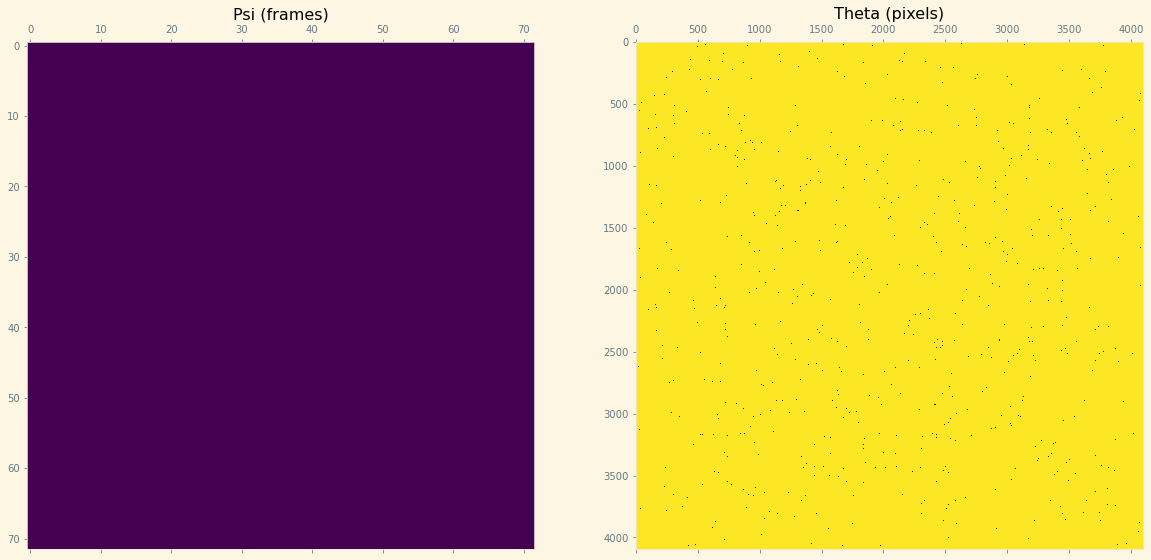

In [38]:
Psi_ = binarize_matrix(Psi, mode='Nonzero')
np.fill_diagonal(Psi_, 1)
Theta_ = binarize_matrix(Theta, mode='Nonzero')
np.fill_diagonal(Theta_, 1)

with plt.style.context('Solarize_Light2'):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 10))
    
    ax1.grid(False)
    ax1.matshow(Psi_)
    ax1.set_title('Psi (frames)')
    
    ax2.matshow(Theta_)
    ax2.grid(False)
    ax2.set_title('Theta (pixels)')

# Tensor

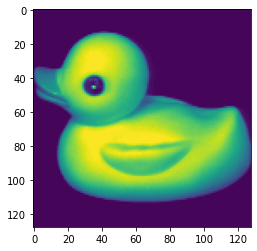

In [5]:
# Here we load the image, and optionally drop every `imsize_factor`th pixel
# if we want to minimize pixels.  In the BiGLasso paper, they considered 9 by 9
import glob
imsize_factor = 1
imsize = 128 // imsize_factor
files = sorted(glob.glob('../../Data/coil-20-proc/*.png'))
duck_tens = np.array(
    [np.array(Image.open(f))[::imsize_factor, ::imsize_factor].reshape(imsize**2) for f in files],
    dtype=np.int16
).reshape((20, 72, imsize, imsize))
duck_tens.shape # object, frame, flattened pixel
plt.imshow(duck_tens[10, 0])

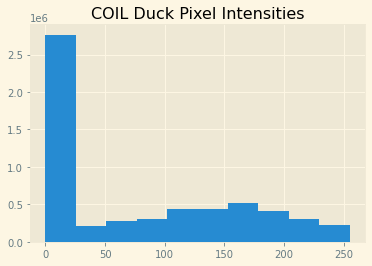

In [309]:
from Scripts.antGLasso import antGLasso
from Scripts.nonparanormal import nonparanormal
from scipy import stats

modified_counts = duck_tens[:, ...].copy().astype(np.float64)

#mask = modified_counts < 10
#modified_counts[mask] = np.random.random(
#    size=modified_counts.shape
#)[mask]*256
#modified_counts[mask!=True] += 246
#modified_counts = (modified_counts+modified_counts.mean()) / 2

#modified_counts[mask] = 257 + stats.norm(scale=50).rvs(size=len(modified_counts[mask]))
#modified_counts = 1 / (np.log(modified_counts+1)+1)

#modified_counts[mask] = stats.binom(n=256, p=0.8).rvs(modified_counts.shape)[mask]

#modified_counts = stats.norm.ppf(stats.nbinom.cdf(modified_counts+1, n=256, p=0.6))
#modified_counts[mask!=True] = np.log(modified_counts[mask!=True])
with plt.style.context('Solarize_Light2'):
    fig, ax = plt.subplots()
    ax.hist(modified_counts.reshape(-1))
    ax.set_title("COIL Duck Pixel Intensities")
    fig.savefig('../../Plots/Final/Histogram for COIL')
pass

In [243]:
Psi, Theta, Eta = antGLasso(
    modified_counts,
    sparsities=[5/70, 0.13, 0.13],
    B_approx_iters=1000
)

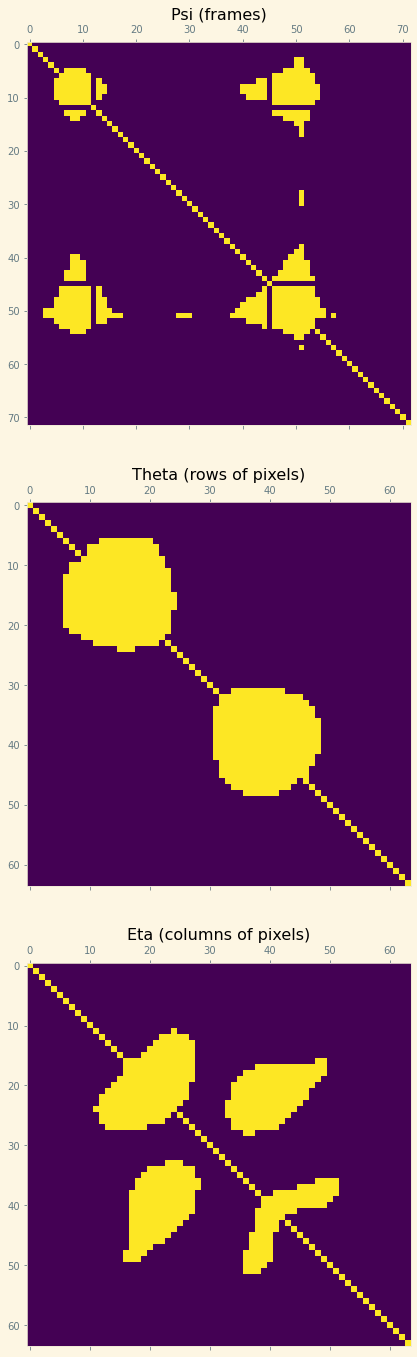

In [244]:
Psi_ = binarize_matrix(Psi, mode='Nonzero')
np.fill_diagonal(Psi_, 1)
Theta_ = binarize_matrix(Theta, mode='Nonzero')
np.fill_diagonal(Theta_, 1)
Eta_ = binarize_matrix(Eta, mode='Nonzero')
np.fill_diagonal(Eta_, 1)

with plt.style.context('Solarize_Light2'):
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, figsize=(12, 24))
    
    ax1.grid(False)
    ax1.matshow(Psi_)
    ax1.set_title('Psi (frames)')
    
    ax2.matshow(Theta_)
    ax2.grid(False)
    ax2.set_title('Theta (rows of pixels)')
    
    ax3.matshow(Eta_)
    ax3.grid(False)
    ax3.set_title('Eta (columns of pixels)')
    
#fig.savefig('../../Plots/Final/antGLasso Duck Performance.png')
#fig.savefig('../../../../out_figs/strange_9.png')

In [16]:
Ss = nonparanormal_tensor_skeptic(duck_tens[10:11])
#print([S.shape for S in Ss])
#antGLasso(duck_tens[10:11], sparsities=[1, 1, 1])
pass

In [17]:
Psi, Theta, Eta = antGLasso_heuristic(
    Ss,
    sparsities=[0.03, 0.012, 0.012],
    B_approx_iters=1000
)

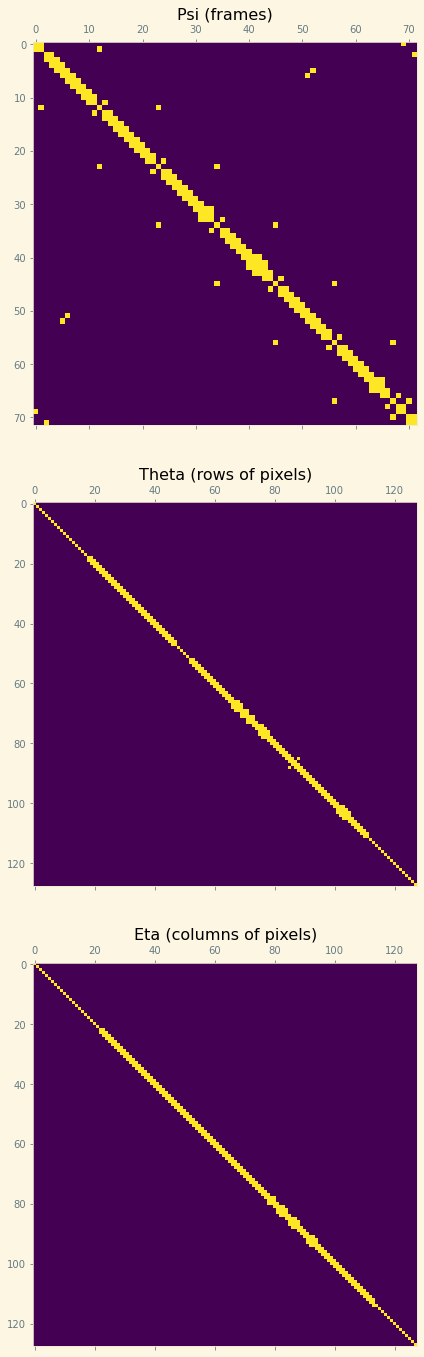

In [18]:
Psi_ = binarize_matrix(Psi, mode='Nonzero')
np.fill_diagonal(Psi_, 1)
Theta_ = binarize_matrix(Theta, mode='Nonzero')
np.fill_diagonal(Theta_, 1)
Eta_ = binarize_matrix(Eta, mode='Nonzero')
np.fill_diagonal(Eta_, 1)

with plt.style.context('Solarize_Light2'):
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, figsize=(8, 24))
    
    ax1.grid(False)
    ax1.matshow(Psi_)
    ax1.set_title('Psi (frames)')
    
    ax2.matshow(Theta_)
    ax2.grid(False)
    ax2.set_title('Theta (rows of pixels)')
    
    ax3.matshow(Eta_)
    ax3.grid(False)
    ax3.set_title('Eta (columns of pixels)')
    
fig.savefig('../../Plots/Final/antGLasso Duck Tensor Performance.png', bbox_inches='tight')
#fig.savefig('../../../../out_figs/strange_9.png')

In [126]:
Psi, Theta, Eta = antGLasso_heuristic(
    Ss,
    sparsities=[1, 1, 1],
    B_approx_iters=1000
)
Psi_sorters = np.sort(np.abs(Psi.reshape(-1)))
Theta_sorters = np.sort(np.abs(Theta.reshape(-1)))
Eta_sorters = np.sort(np.abs(Eta.reshape(-1)))

<IPython.core.display.Javascript object>


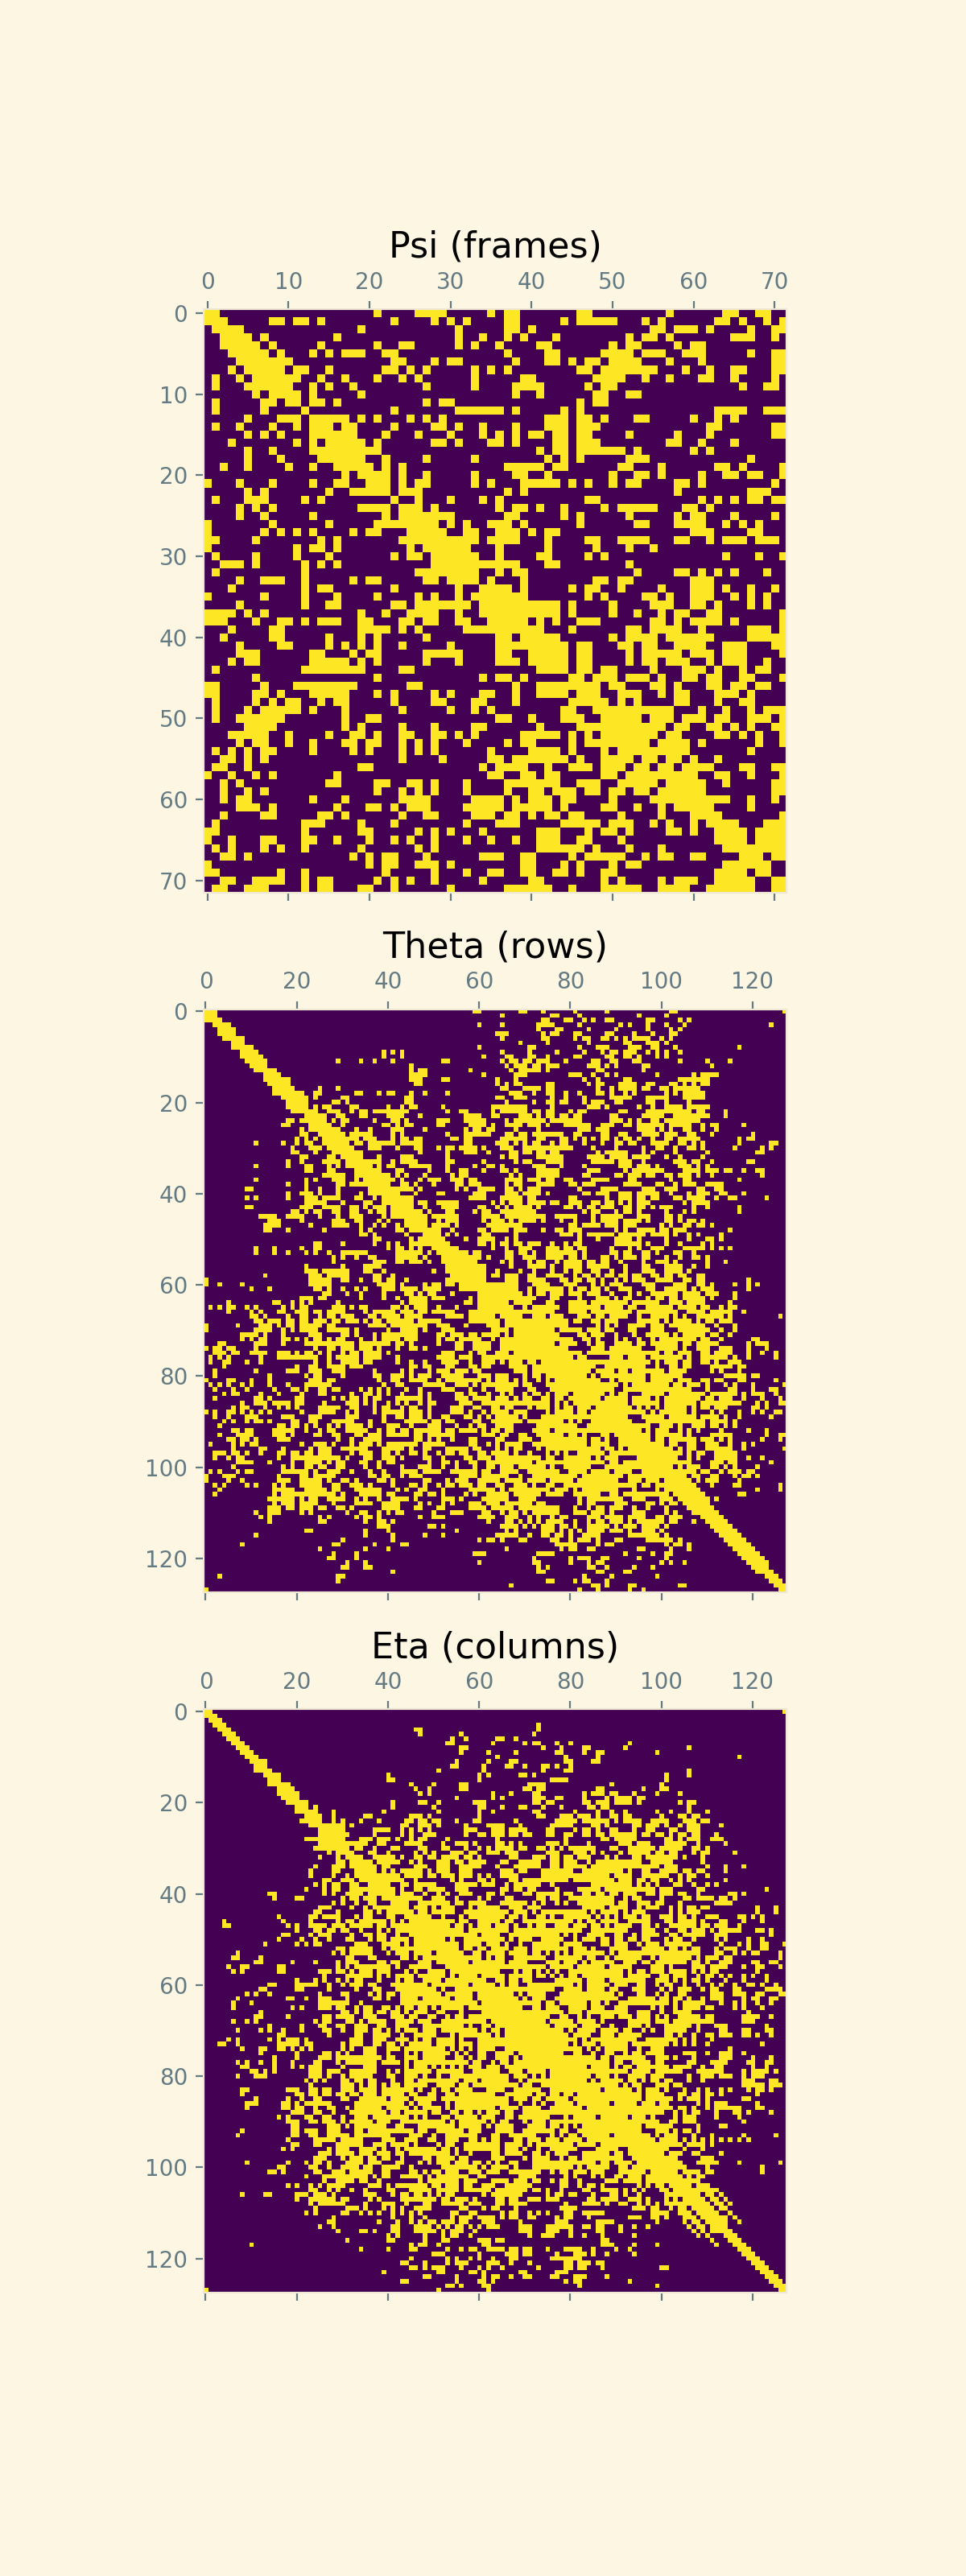

In [128]:
num_frames = 200
from  matplotlib.animation import FuncAnimation, PillowWriter
%matplotlib notebook
# Don't bother with Theta since sizes are different, makes things complicated...
with plt.style.context('Solarize_Light2'):

    fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, figsize=(6, 16))

    ax1.grid(False)
    ax1.set_title('Psi (frames)')
    Psi_ = np.zeros(Psi.shape)
    Psi_ = binarize_matrix(Psi_, mode='Nonzero')
    np.fill_diagonal(Psi_, 1)
    mat_psi = ax1.matshow(Psi_)
    
    ax2.grid(False)
    ax2.set_title('Theta (rows)')
    Theta_ = np.zeros(Theta.shape)
    Theta_ = binarize_matrix(Theta_, mode='Nonzero')
    np.fill_diagonal(Theta_, 1)
    mat_theta = ax2.matshow(Theta_)
    
    ax3.grid(False)
    ax3.set_title('Eta (columns)')
    Eta_ = np.zeros(Eta.shape)
    Eta_ = binarize_matrix(Eta_, mode='Nonzero')
    np.fill_diagonal(Eta_, 1)
    mat_eta = ax3.matshow(Eta_)

    def update(idx):# 0 to 82943
        Psi_ = Psi.copy()
        Psi_[np.abs(Psi_) < Psi_sorters[
            int((idx/num_frames) * len(Psi_sorters))
        ]] = 0
        Psi_ = binarize_matrix(Psi_, mode='Nonzero')
        np.fill_diagonal(Psi_, 1)
        mat_psi.set_data(Psi_)
        
        Theta_ = Theta.copy()
        Theta_[np.abs(Theta_) < Theta_sorters[
            int((idx/num_frames) * len(Theta_sorters))
        ]] = 0
        Theta_ = binarize_matrix(Theta_, mode='Nonzero')
        np.fill_diagonal(Theta_, 1)
        mat_theta.set_data(Theta_)
        
        Eta_ = Eta.copy()
        Eta_[np.abs(Eta_) < Eta_sorters[
            int((idx/num_frames) * len(Eta_sorters))
        ]] = 0
        Eta_ = binarize_matrix(Eta_, mode='Nonzero')
        np.fill_diagonal(Eta_, 1)
        mat_eta.set_data(Eta_)
        
        return [mat_psi, mat_theta, mat_eta]
    
    anim = FuncAnimation(fig, update, frames=num_frames, interval = 1, blit=True)
    anim.save("../../Plots/Final/antGLasso COIL.gif", dpi=80, writer=PillowWriter(fps=25))

    


# What happens if we mix data?

In [48]:
DUCK = duck_tens[10:11]
mixed = np.empty(DUCK.shape)
_, f, r, c = DUCK.shape
#mixed[:, :f//2, :, :] = DUCK[:, f//2:, :, :]
#mixed[:, :, :r//2, :] = DUCK[:, :, r//2:, :]
#mixed[:, :, :, :c//2] = DUCK[:, :, :, c//2:]
#mixed[:, f//2:, :, :] = DUCK[:, :f//2, :, :]
#mixed[:, :, r//2:, :] = DUCK[:, :, :r//2, :]
#mixed[:, :, :, c//2:] = DUCK[:, :, :, :c//2]
#mixed[:, 0::2, :, :] = DUCK[:, 1::2, :, :]
#mixed[:, 1::2, :, :] = DUCK[:, 0::2, :, :]
#mixed[:, :, 0::2, :] = DUCK[:, :, 1::2, :]
#mixed[:, :, 1::2, :] = DUCK[:, :, 0::2, :]
#mixed[:, :, :, 0::2] = DUCK[:, :, :, 1::2]
#mixed[:, :, :, 1::2] = DUCK[:, :, :, 0::2]
np.random.shuffle(mixed)

In [49]:
Ss = nonparanormal_tensor_skeptic(mixed)

In [50]:
Psi, Theta, Eta = antGLasso_heuristic(
    Ss,
    sparsities=[0.03, 0.012, 0.012],
    B_approx_iters=1000
)

<IPython.core.display.Javascript object>


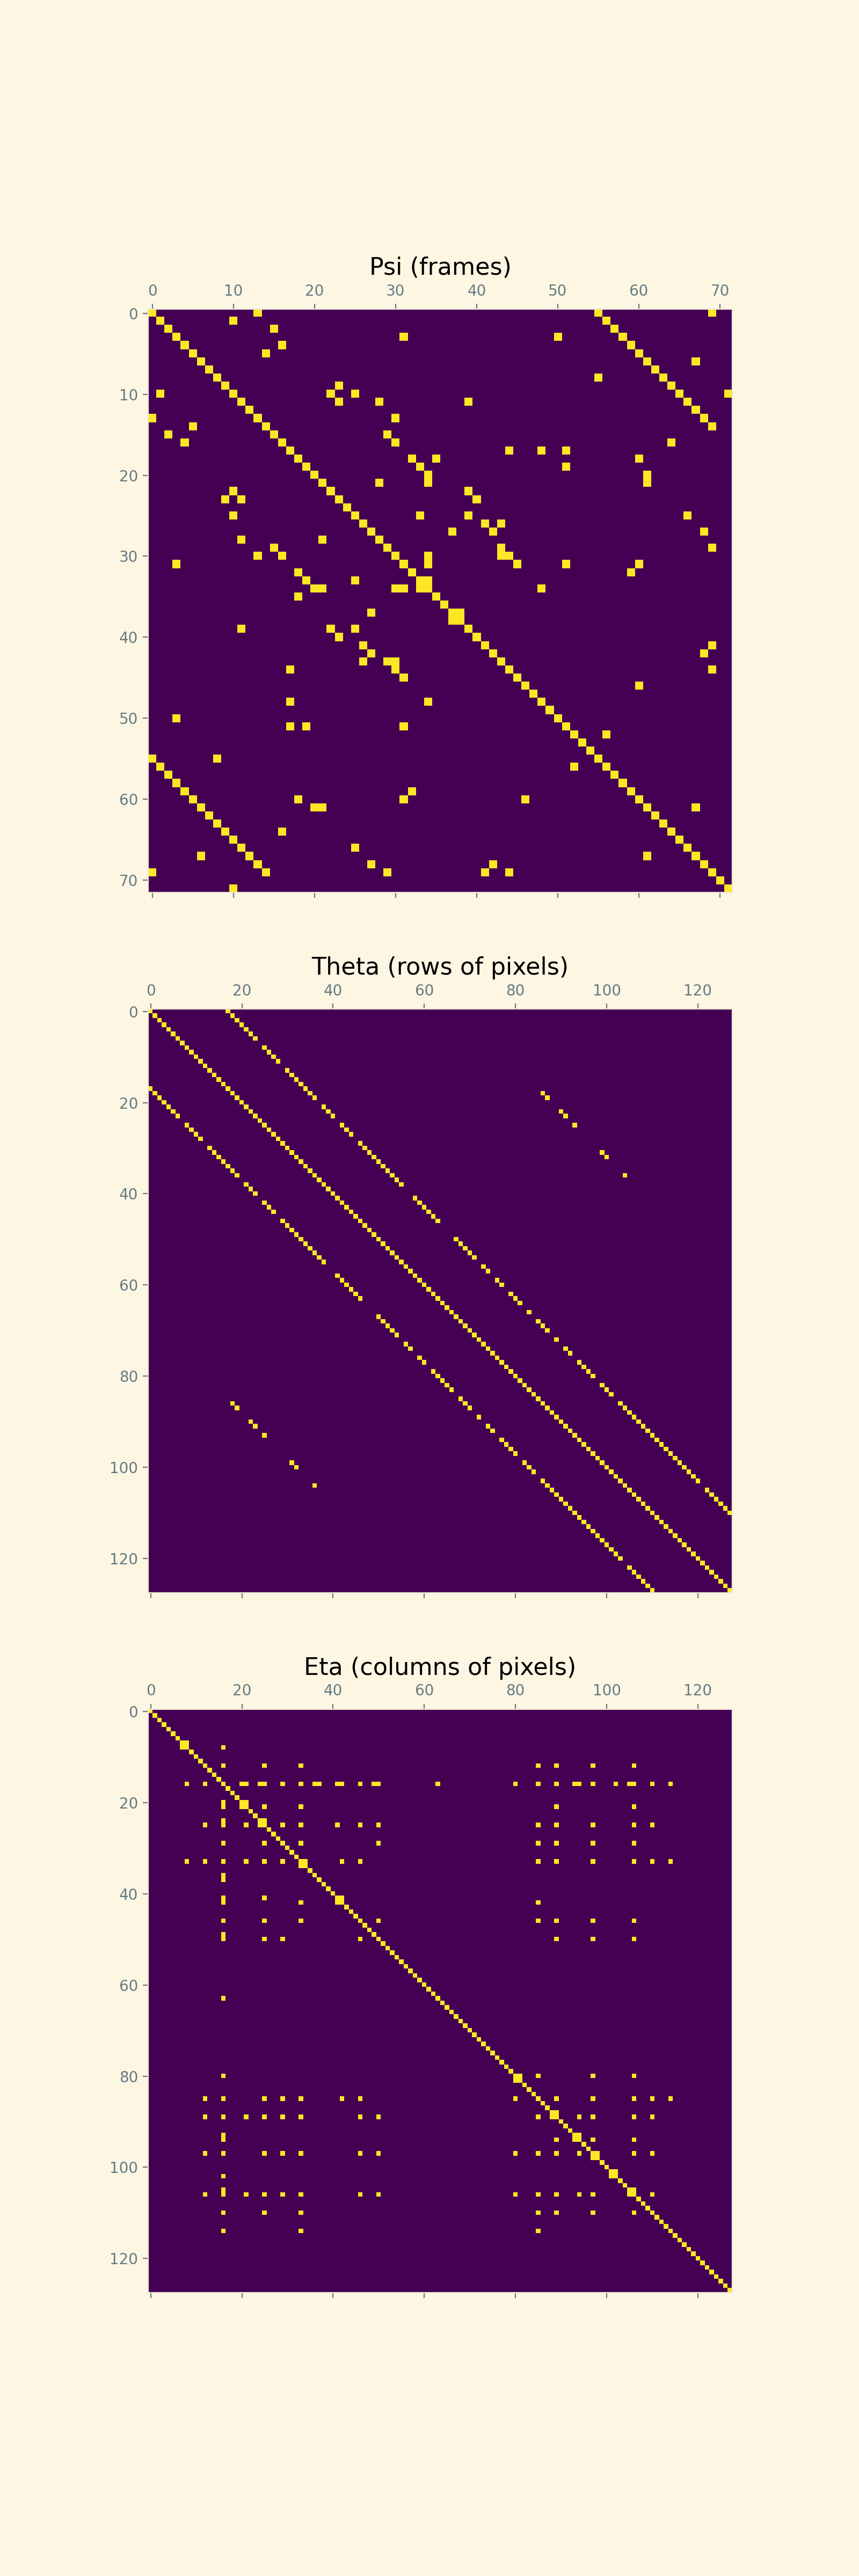

In [52]:
Psi_ = binarize_matrix(Psi, mode='Nonzero')
np.fill_diagonal(Psi_, 1)
Theta_ = binarize_matrix(Theta, mode='Nonzero')
np.fill_diagonal(Theta_, 1)
Eta_ = binarize_matrix(Eta, mode='Nonzero')
np.fill_diagonal(Eta_, 1)

with plt.style.context('Solarize_Light2'):
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, figsize=(8, 24))
    
    ax1.grid(False)
    ax1.matshow(Psi_)
    ax1.set_title('Psi (frames)')
    
    ax2.matshow(Theta_)
    ax2.grid(False)
    ax2.set_title('Theta (rows of pixels)')
    
    ax3.matshow(Eta_)
    ax3.grid(False)
    ax3.set_title('Eta (columns of pixels)')
    
fig.savefig('../../Plots/Final/antGLasso Duck Tensor Shuffled.png', bbox_inches='tight')

In [53]:
Psi, Theta, Eta = antGLasso_heuristic(
    Ss,
    sparsities=[1, 1, 1],
    B_approx_iters=1000
)
Psi_sorters = np.sort(np.abs(Psi.reshape(-1)))
Theta_sorters = np.sort(np.abs(Theta.reshape(-1)))
Eta_sorters = np.sort(np.abs(Eta.reshape(-1)))

<IPython.core.display.Javascript object>


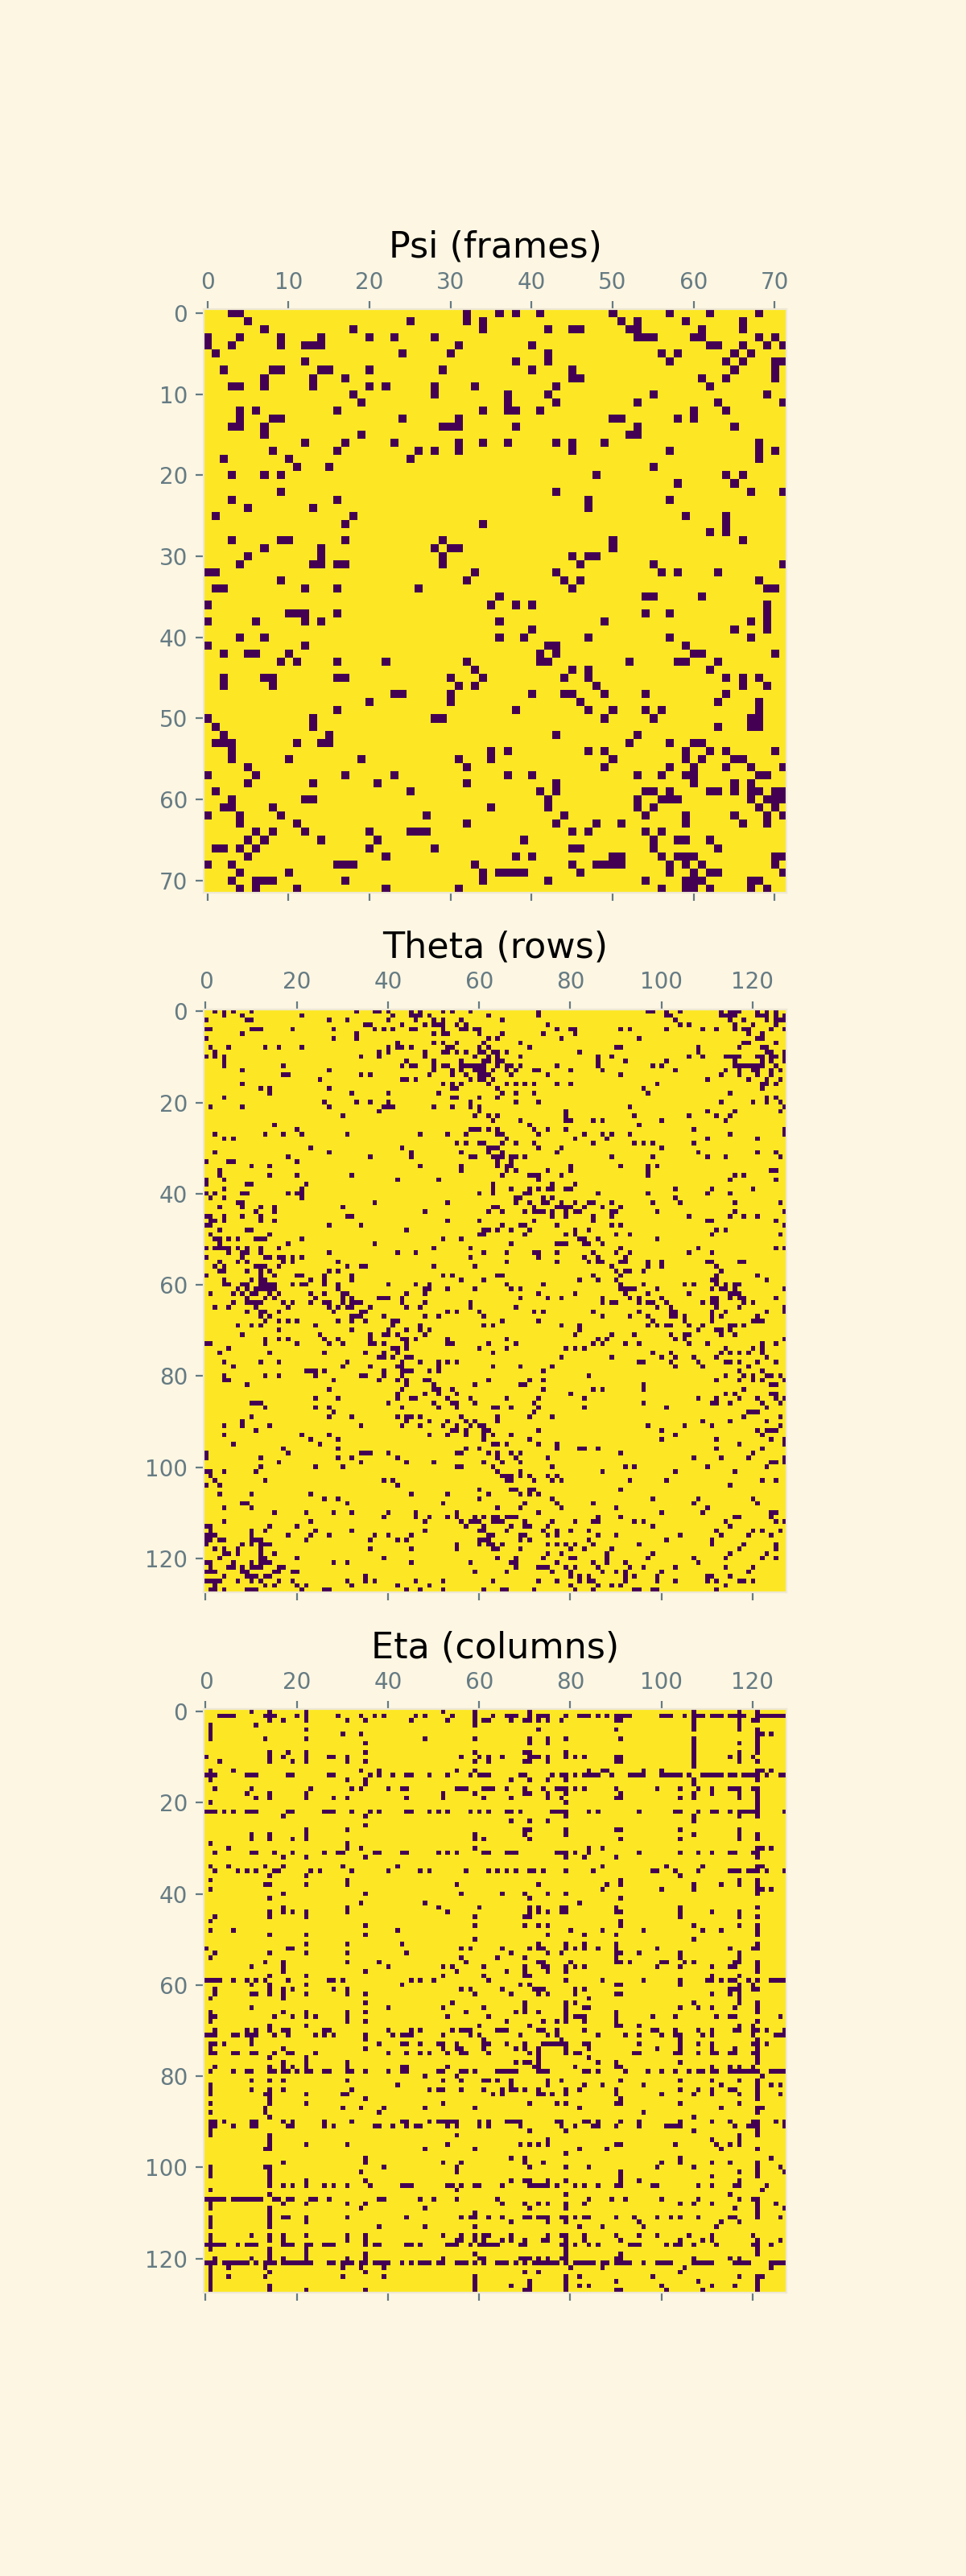

In [54]:
num_frames = 200
from  matplotlib.animation import FuncAnimation, PillowWriter
%matplotlib notebook
# Don't bother with Theta since sizes are different, makes things complicated...
with plt.style.context('Solarize_Light2'):

    fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, figsize=(6, 16))

    ax1.grid(False)
    ax1.set_title('Psi (frames)')
    Psi_ = np.zeros(Psi.shape)
    Psi_ = binarize_matrix(Psi_, mode='Nonzero')
    np.fill_diagonal(Psi_, 1)
    mat_psi = ax1.matshow(Psi_)
    
    ax2.grid(False)
    ax2.set_title('Theta (rows)')
    Theta_ = np.zeros(Theta.shape)
    Theta_ = binarize_matrix(Theta_, mode='Nonzero')
    np.fill_diagonal(Theta_, 1)
    mat_theta = ax2.matshow(Theta_)
    
    ax3.grid(False)
    ax3.set_title('Eta (columns)')
    Eta_ = np.zeros(Eta.shape)
    Eta_ = binarize_matrix(Eta_, mode='Nonzero')
    np.fill_diagonal(Eta_, 1)
    mat_eta = ax3.matshow(Eta_)

    def update(idx):# 0 to 82943
        Psi_ = Psi.copy()
        Psi_[np.abs(Psi_) < Psi_sorters[
            int((idx/num_frames) * len(Psi_sorters))
        ]] = 0
        Psi_ = binarize_matrix(Psi_, mode='Nonzero')
        np.fill_diagonal(Psi_, 1)
        mat_psi.set_data(Psi_)
        
        Theta_ = Theta.copy()
        Theta_[np.abs(Theta_) < Theta_sorters[
            int((idx/num_frames) * len(Theta_sorters))
        ]] = 0
        Theta_ = binarize_matrix(Theta_, mode='Nonzero')
        np.fill_diagonal(Theta_, 1)
        mat_theta.set_data(Theta_)
        
        Eta_ = Eta.copy()
        Eta_[np.abs(Eta_) < Eta_sorters[
            int((idx/num_frames) * len(Eta_sorters))
        ]] = 0
        Eta_ = binarize_matrix(Eta_, mode='Nonzero')
        np.fill_diagonal(Eta_, 1)
        mat_eta.set_data(Eta_)
        
        return [mat_psi, mat_theta, mat_eta]
    
    anim = FuncAnimation(fig, update, frames=num_frames, interval = 1, blit=True)
    anim.save("../../Plots/Final/antGLasso COIL Mixed.gif", dpi=80, writer=PillowWriter(fps=25))

    
